Lưu ý :
- Một số toolkit phải cần dùng GPU để import ví dụ face_recognition .
- GPU được sử dụng giới hạn nên hoặc là đợi sau đó sử dụng lại được hoặc share folder này ra nhiều tài khoản google khác để chạy
- Error ```CUDA driver version is insufficient for CUDA runtime version```

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install face_recognition
!pip install git+https://github.com/rcmalli/keras-vggface.git
!pip install keras_vggface
!pip install keras_applications
!pip install keras==2.12

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566170 sha256=b321ba22a3770d087aea806d611f5cd61eff1f11884ce670096d2aac5a95420c
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models
  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-jknmixtg
  Running command git clone --filter=blob:none --quiet https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-jknmixtg
  Resolved https://github.com/rcmalli/keras-vggface.git to commit bee35376e76e35d00aeec503f2f242611a97b38a
  Preparing metadata (setup.py) ... done
  Created wheel for keras-vggface: filename=keras_vggface-0.6-py3-none-any.whl size=8294 sha256=4d2cf5cb9606ef904dc0466c9d5c1b45b91e239ea74d9e8f8724f88828a93e23
  Stored in 

In [ ]:
import os
os.chdir('/content/drive/MyDrive/DeepLearning/Research/Face_Recognition') # Chỉ định nơi làm việc (terminal)


In [ ]:
# import sys
# sys.path.append('/content/drive/MyDrive/Colab Notebooks/keras-vggface')

- Run camera in google colab : https://stackoverflow.com/questions/54389727/opening-web-camera-in-google-colab
- Document Research : https://github.com/facebookresearch/faiss

#### Import toolkit

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model , load_model
from keras.optimizers import Adam
from keras_vggface.vggface import VGGFace

import tensorflow as tf
import face_recognition
import cv2
import pickle
from PIL import Image
from keras_vggface import utils

import random
from imutils import paths
from sklearn.preprocessing import LabelEncoder

from datetime import datetime

#### Sử dụng các lớp Conv của VGGFace SEnet50 kết hợp với các lớp Fully conected của ta tự xây để trích xuất vector đặc trưng .

Lưu ý :
- Không sử dụng lớp Dense activation softmax (vì ta chỉ trích xuất vector đặc trưng chứ không dự đoán)
- Cách 1 : Ta có thể làm như sau , như đã nói là từ output của SENet50 , kết hợp với Fully conected của ta tự xây để VỪA GIẢM CHIỀU và VỪA TRÍCH XUẤT ĐẶC TRƯNG .
- Cách 2 : Hoặc ta có thể chỉ sử dụng Conv của SENet50 để trích xuất vector đặc trưng sau đó sử dụng PCA để giảm chiều
- => Dùng cách nào cũng được nhưng có vẻ như với cách 1 thì model học được các đặt tính của ảnh kĩ hơn còn PCA thường sẽ đánh mất một phần đặc tính của ảnh

In [ ]:
# myConvNetModelVGG16 = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))
# Ví dụ Khi đặt weights='imagenet', mô hình VGG16 sẽ được tải với các trọng số đã được đào tạo trước trên tập dữ liệu lớn ImageNet.

In [ ]:
# VGGFace, không cần thiết phải chỉ định weights='imagenet' vì mô hình đã được huấn luyện trước trên tập dữ liệu riêng của nó.
base_model = VGGFace(include_top=False,model='senet50',input_shape=(224, 224, 3))
# base_model.summary()

myFCHead = base_model.output # (None, 1, 1, 2048) # lớp cuối của Conv VGGFace
myFCHead = GlobalAveragePooling2D()(myFCHead) # flatten # Cách 1 # làm phẳng
# myFCHead = Flatten(name='flatten')(myFCHead) # 1x1x2048 = 2048 # Cách 2
myFCHead = Dense(1024, activation='relu')(myFCHead)
myFCHead = Dense(1024, activation='relu')(myFCHead) # double 1024 chỉ để tăng số lượng tham số
myFCHead = Dense(512, activation='relu')(myFCHead)
myFCHead = Dense(128)(myFCHead) # output img is vector 128 dimensional
myModel = Model(inputs=base_model.input, outputs=myFCHead)
# myModel.summary()

# final layer with softmax activation

Compile model

In [ ]:
myModel.compile(optimizer='Adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

Lưu model lại để sử dụng cho sau này , đỡ phải chạy lại từ đầu

In [ ]:
# bỏ qua bước này nếu đã có file này
# myModel.save('./save_models/VGGFace_SENet_Transfer_Model.h5')

Load model

Load model với trọng số của VGG Face SENet50

In [ ]:
vggSENet50 = load_model('./save_models/VGGFace_SENet_Transfer_Model.h5')

#### Trích xuất vector đặc trưng

Các bước tiến hành :
1. EncodeListKnow để  để lưu trữ các vectơ đặc trưng của các khuôn mặt
2. Classnames để lưu trữ tên nhãn (lớp)
3. Lấy ra path của tất cả các ảnh trong folder train , lặp qua các path và thực hiện
4. Chuyển ảnh về RGB
5. Phát hiện khuông mặt trong ảnh bằng `face_recognition`
    - Dataset thực tế chỉ có một khuông mặt trong một ảnh , nhưng ở đây làm theo kiểu tổng quát
    - Đếm số khuông mặt trong ảnh , lấy ra khuông mặt , lặp qua từng khuông mặt
        - Resize về 224*224 và chuẩn hóa để chuẩn bị dữ liệu cho dự đoán
        - Thêm dữ liệu vào list list_image
        - Thêm class tương ứng của ảnh vào classnames
6. Trích xuất vector đặc trưng khuông mặt với dữ liệu đầu vào là list_image[] và dữ liệu đầu ra sẽ là EncodeListKnow[]
7. Lưu `encodeListKnow` và `classnames` vào các tệp CSV để sử dụng cho việc huấn luyện mô hình sau này.

Feature Extractor Def

In [ ]:
def prepare_input_data (image_path) :
  count = 0
  list_image = []
  classnames = []
  target_size = (224 , 224)
  for (index_img, imagePath) in enumerate(image_path):
      name = imagePath.split("/")[-2]
      print(name)
      imagetest = face_recognition.load_image_file(imagePath)
      imagetest = cv2.cvtColor(imagetest, cv2.COLOR_BGR2RGB)
      # detect face
      faces = face_recognition.face_locations(imagetest)
      # if not exactly 1 face is detected, skip this photo
      if len(faces) == 0:
          continue
      count += 1
      print(count)
      for (y1, x2, y2, x1) in faces:
          # detected face region & resize the detected face to 224x224
          roi = imagetest[y1:y2, x1:x2]
          resized_image = cv2.resize(roi, target_size)
          # prepare the image for prediction
          x = tf.keras.preprocessing.image.img_to_array(resized_image)
          x = np.expand_dims(x, axis=0)
          x = utils.preprocess_input(x, version=1)
          list_image.append(x)
          classnames.append(name)
  # Chuyển danh sách các ảnh thành mảng numpy một chiều
  list_image = np.vstack(list_image)
  return list_image, classnames

#### Train

In [ ]:
train_image_path = list(paths.list_images('./Dataset/train'))
random.shuffle(train_image_path)

In [ ]:
train_list_image, train_classnames = prepare_input_data(train_image_path)

Trích xuất vector đặc trưng

In [ ]:
print(train_list_image.shape)
train_features = vggSENet50.predict(train_list_image) # tensor Đặc trưng ảnh
print(train_features.shape)

Lưu dữ liệu vào .csv (Tạo trước folder này)

In [ ]:
df = pd.DataFrame(train_features)
dfname = pd.DataFrame(train_classnames)
df.to_csv("./CSVfile/train_face_features.csv", index=False)
dfname.to_csv("./CSVfile/train_face_classnames.csv", index=False)

#### Test

In [ ]:
test_image_path = list(paths.list_images('./Dataset/test_unknow'))
random.shuffle(test_image_path)

In [ ]:
test_list_image, test_classnames = prepare_input_data(test_image_path)

In [ ]:
test_unknow_features = vggSENet50.predict(test_list_image)

In [ ]:
df = pd.DataFrame(test_unknow_features)
dfname = pd.DataFrame(test_classnames)
df.to_csv("./CSVfile/test_unknow_face_features.csv", index=False)
dfname.to_csv("./CSVfile/test_unknow_face_classnames.csv", index=False)

#### Face Recognition
- Core của bài toán nằm ở chỗ : face_recognition.face_distance()
- Với bài toán số nhãn thay đổi , thay vì đi traning model rồi nhận dạng chỉ các nhãn nằm trong danh sách nhãn đã traning thì ta có nhãn mới cần nhận dạng.
- Tìm chỉ số (cũng như label) feature vector khuôn mặt trong database có khoảng cách nhỏ nhất với feature vector khuôn mặt được nhận diện .
- Nếu khoảng cách nhỏ hơn 15 (ngưỡng ngưỡng quyết định được chọn bằng cách thử nghiệm), thì ghi thông tin tham dự vào tệp attend.csv. Nếu không, gán tên là "UNKNOW".

#### Tìm ngưỡng

#### Đánh giá độ chính xác

In [ ]:
train_features = pd.read_csv('./CSVfile/train_face_features.csv')
train_classnames = pd.read_csv('./CSVfile/train_face_classnames.csv')
print(train_features.shape)
print(train_classnames.shape)

test_features = pd.read_csv('./CSVfile/test_unknow_face_features.csv')
test_classnames = pd.read_csv('./CSVfile/test_unknow_face_classnames.csv')
print(test_features.shape)
print(test_classnames.shape)

(146, 128)
(146, 1)
(85, 128)
(85, 1)


Chuyển dữ liệu từ DataFrame sang numpy array

In [ ]:
# Chuyển dữ liệu từ DataFrame sang numpy array
train_features = np.array(train_features)
train_classnames = np.array(train_classnames).reshape(-1)

test_features = np.array(test_features)
test_classnames = np.array(test_classnames).reshape(-1)

#### Khảo sát ngưỡng để tìm ra ngưỡng cho độ chính xác cao nhất

Hàm dự đoán nhãn của các vector trong tập test dựa trên tập train

In [ ]:
# Hàm dự đoán nhãn của các vector trong tập test dựa trên tập train
def predict_labels(train_features, train_classnames, test_features, threshold=0.6):
    predictions = []
    for test_feature in test_features:
        face_distances = face_recognition.face_distance(train_features, test_feature)
        min_distance_index = np.argmin(face_distances)
        min_distance = face_distances[min_distance_index]
        if min_distance <= threshold:
            prediction = train_classnames[min_distance_index]
        else:
            prediction = "UNKNOW"
        predictions.append(prediction)
    return predictions

Khảo sát ngưỡng

Threshold: 1 , Accuracy: 12.941176470588237 %
Threshold: 2 , Accuracy: 12.941176470588237 %
Threshold: 3 , Accuracy: 12.941176470588237 %
Threshold: 4 , Accuracy: 14.117647058823529 %
Threshold: 5 , Accuracy: 16.470588235294116 %
Threshold: 6 , Accuracy: 22.35294117647059 %
Threshold: 7 , Accuracy: 34.11764705882353 %
Threshold: 8 , Accuracy: 40.0 %
Threshold: 9 , Accuracy: 58.82352941176471 %
Threshold: 10 , Accuracy: 78.82352941176471 %
Threshold: 11 , Accuracy: 83.52941176470588 %
Threshold: 12 , Accuracy: 84.70588235294117 %
Threshold: 13 , Accuracy: 84.70588235294117 %
Threshold: 14 , Accuracy: 85.88235294117646 %
Threshold: 15 , Accuracy: 89.41176470588236 %
Threshold: 16 , Accuracy: 88.23529411764706 %
Threshold: 17 , Accuracy: 83.52941176470588 %
Threshold: 18 , Accuracy: 83.52941176470588 %
Threshold: 19 , Accuracy: 83.52941176470588 %
Threshold: 20 , Accuracy: 82.35294117647058 %
Threshold: 21 , Accuracy: 81.17647058823529 %
Threshold: 22 , Accuracy: 81.17647058823529 %
Thres

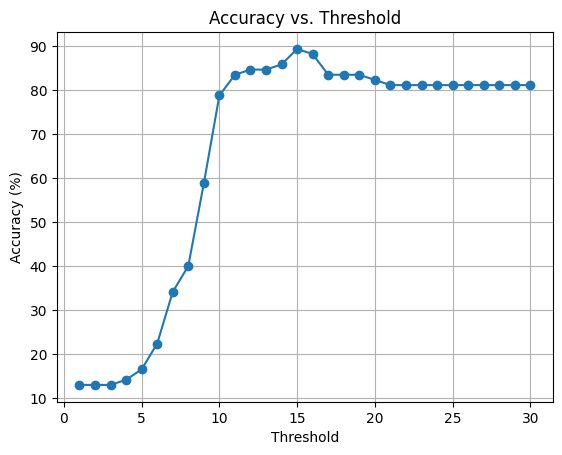

In [ ]:
# Khởi tạo mảng để lưu độ chính xác của từng ngưỡng
accuracies = []
for threshold in range(1, 31):  # Chạy từ 1 đến 30
    # Dự đoán nhãn của các vector trong tập test
    predicted_labels = predict_labels(train_features, train_classnames, test_features, threshold)
    # Tính độ chính xác và lưu vào mảng accuracies
    accuracy = np.mean(predicted_labels == test_classnames) * 100
    accuracies.append(accuracy)
    # In kết quả
    print("Threshold:", threshold, ", Accuracy:", accuracy, "%")
# Vẽ đồ thị
plt.plot(range(1, 31), accuracies, marker='o')
plt.title('Accuracy vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.show()


In [ ]:
# Ngưỡng cho độ chính xác cao nhấy là 15
# Dự đoán nhãn của các vector trong tập test
threshold = 15  # Ngưỡng khoảng cách
predicted_labels = predict_labels(train_features, train_classnames, test_features, threshold)

# Tính độ chính xác
accuracy = np.mean(predicted_labels == test_classnames) * 100
print("Accuracy:", accuracy, "%")

Accuracy: 89.41176470588236 %


#### Dự đoán thực tế

In [ ]:
real_test_image_path = list(paths.list_images('./Dataset/real_test'))
print(real_test_image_path)
real_test_list_image, real_test_classnames = prepare_input_data(real_test_image_path)
real_test_features = vggSENet50.predict(real_test_list_image)

['./Dataset/real_test/Manh (3).jpg', './Dataset/real_test/Manh (2).jpg', './Dataset/real_test/Manh (1).jpg', './Dataset/real_test/4 Face.jpg']
real_test
1
real_test
2
real_test
3
real_test
4
1/1 [==============================] - 0s 47ms/step


In [ ]:
predicted_labels = predict_labels(train_features, train_classnames, real_test_features, threshold = 15)

In [ ]:
print(predicted_labels)

['UNKNOW', 'Manh', 'Manh', 'UNKNOW', 'Cuong', 'UNKNOW', 'UNKNOW']
